# Test mutual information estimators

## Preamble

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import torch

device = 'cuda'

SEED = 9195
np.random.seed(SEED)

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
font = {'family' : 'DejaVu Sans',
        'size'   : 18}

matplotlib.rc('font', **font)

In [4]:
import os
import json
import csv

from datetime import datetime
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

In [5]:
from pathlib import Path
path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../../data/"))

In [6]:
experiments_path = path + "/mutual_information/synthetic/"

#### Importing the module

In [7]:
import mutinfo.estimators.mutual_information as mi_estimators
from mutinfo.utils.dependent_norm import *
from mutinfo.utils.synthetic import normal_to_uniform

In [8]:
### SETTINGS ###
entropy_estimator_params = \
{
    'method': 'KL',
    'functional_params': {'n_jobs': 2, 'k_neighbours': 5},
}

#### Standard tests with arbitrary mapping

In [9]:
entropy_estimator_params

{'method': 'KL', 'functional_params': {'n_jobs': 2, 'k_neighbours': 5}}

In [10]:
def sample_spherical(dim, n_projections):
    sampled_vectors = np.array([]).reshape(0,dim)
    while len(sampled_vectors) < n_projections:
        vec = np.random.multivariate_normal(np.zeros(dim), np.identity(dim), size=dim) # (num_vec, dim)
        vec = np.linalg.qr(vec).Q
        sampled_vectors = np.vstack((sampled_vectors, vec))
    return sampled_vectors[:n_projections] # (num_vec, dim)
    
class smi_compressor():
    def __init__(self, dim, n_projections):
        self.theta = sample_spherical(dim=dim, n_projections=n_projections) # (n_projections, dim)
        
    def __call__(self, X):
        # getting projections
        X_compressed = np.dot(self.theta, X.T)
        return X_compressed # m x n
    
def get_mi_wkl(X_L_mi_estimator, X_compressed, L_compressed, entropy_estimator_params):
    """
    input: 
        1d vectors, projections of n samples of X and L
    """
    X_L_mi_estimator = mi_estimators.MutualInfoEstimator(entropy_estimator_params=entropy_estimator_params)
    X_L_mi_estimator.fit(X_compressed, L_compressed, verbose=0)
    X_L_mi_ = X_L_mi_estimator.estimate(X_compressed, L_compressed, verbose=0)
    return X_L_mi_

In [11]:
def perform_normal_compressed_test(mi, n_samples, X_dimension, Y_dimension, X_map=None, Y_map=None,
                                   X_compressor=None, Y_compressor=None, verbose=0, is_smi=False, n_projections=100,
                                   ):
    random_variable = multivariate_normal_from_MI(X_dimension, Y_dimension, mi) 
    X_Y = random_variable.rvs(n_samples) 
    X = X_Y[:, 0:X_dimension] 
    Y = X_Y[:, X_dimension:X_dimension + Y_dimension]

    # Default MI estimation.
    mi_estimator = mi_estimators.MutualInfoEstimator(entropy_estimator_params=entropy_estimator_params)
    mi_estimator.fit(X, Y, verbose=verbose)
    mi = mi_estimator.estimate(X, Y, verbose=verbose)
    # mi = (0,0)
    
    comp_X = smi_compressor(X.shape[1], n_projections=n_projections)
    comp_Y = smi_compressor(Y.shape[1], n_projections=n_projections)
    
    results = Parallel(n_jobs=4)\
        (delayed(get_mi_wkl)(mi_estimator, X_compressed.reshape(-1,1), L_compressed.reshape(-1,1), entropy_estimator_params) \
        for X_compressed, L_compressed in zip(comp_X(X), (comp_Y(Y))))
    mi_compressed = np.mean(results, axis=0)
    
    return mi, mi_compressed

In [12]:
def perform_normal_compressed_tests_MI(MI, n_samples, X_dimension, Y_dimension, X_map=None, Y_map=None,
                                       X_compressor=None, Y_compressor=None, verbose=0, 
                                       is_smi=False, n_projections=100):
    """
    Estimate mutual information for different true values
    (transformed normal distribution).
    """
    n_exps = len(MI)
    
    # Mutual information estimates.
    estimated_MI = []
    estimated_MI_compressed = []

    # Conducting the tests.
    for n_exp in (range(n_exps)):
        # print("\nn_exp = %d/%d\n------------\n" % (n_exp + 1, n_exps))
        mi, compressed_mi = perform_normal_compressed_test(MI[n_exp], n_samples, X_dimension, Y_dimension,
                                                           X_map, Y_map, X_compressor, Y_compressor, verbose, 
                                                           is_smi=is_smi, n_projections=n_projections)
        estimated_MI.append(mi)
        estimated_MI_compressed.append(compressed_mi)
        
    return np.array(estimated_MI), np.array(estimated_MI_compressed)

In [13]:
def plot_estimated_compressed_MI(MI, estimated_MI, estimated_MI_compressed, title):
    estimated_MI_mean = np.array([estimated_MI[index][0] for index in range(len(estimated_MI))])
    estimated_MI_std  = np.array([estimated_MI[index][1] for index in range(len(estimated_MI))])
    
    estimated_MI_compressed_mean = np.array([estimated_MI_compressed[index][0]
                                             for index in range(len(estimated_MI_compressed))])
    estimated_MI_compressed_std  = np.array([estimated_MI_compressed[index][1]
                                             for index in range(len(estimated_MI_compressed))])
    
    fig_normal, ax_normal = plt.subplots()

    fig_normal.set_figheight(11)
    fig_normal.set_figwidth(16)

    # Grid.
    ax_normal.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax_normal.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

    ax_normal.set_title(title)
    ax_normal.set_xlabel("$I(X,Y)$")
    ax_normal.set_ylabel("$\\hat I(X,Y)$")
    
    ax_normal.minorticks_on()
    
    #ax_normal.set_yscale('log')
    #ax_normal.set_xscale('log')

    ax_normal.plot(MI, MI, label="$I(X,Y)$", color='red')
    
    ax_normal.plot(MI, estimated_MI_mean, label="$\\hat I(X,Y)$"+f", Correlation={np.corrcoef(MI, estimated_MI_mean)[0,1]:.3f}")
    ax_normal.fill_between(MI, estimated_MI_mean + estimated_MI_std, estimated_MI_mean - estimated_MI_std, alpha=0.2)
    
    ax_normal.plot(MI, estimated_MI_compressed_mean, label="$\\hat I_{SMI}(X,Y)$"+f", Correlation={np.corrcoef(MI, estimated_MI_compressed_mean)[0,1]:.3f}")
    ax_normal.fill_between(MI, estimated_MI_compressed_mean + estimated_MI_compressed_std,
                           estimated_MI_compressed_mean - estimated_MI_compressed_std, alpha=0.2)

    ax_normal.legend(loc='upper left', fontsize=30)

    ax_normal.set_xlim((0.0, max(MI)))
    ax_normal.set_ylim((0.0, max(MI)))

    plt.show();

### Global parameters

In [14]:
# The values of mutual information under study.
MI = np.linspace(0.0, 4.0, 21)
n_exps = len(MI)

# Sample size and dimensions of vectors X and Y.
n_samples = 100 # 5000
X_dimension = 10
Y_dimension = 10


## Sliced Mutual Information

#### MI vs SMI comparison

  0%|          | 0/4 [00:00<?, ?it/s]

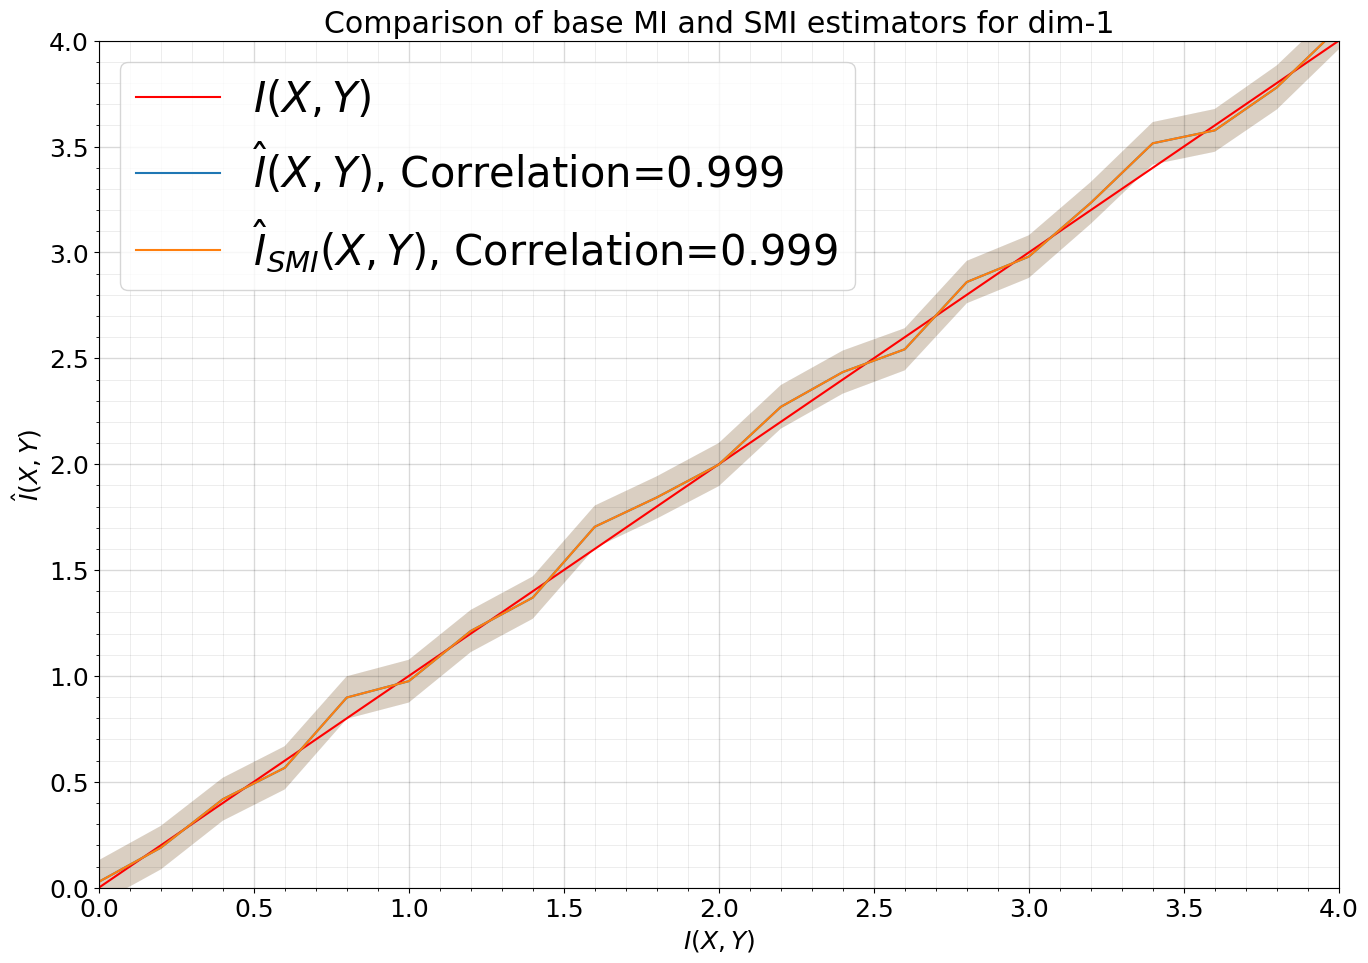

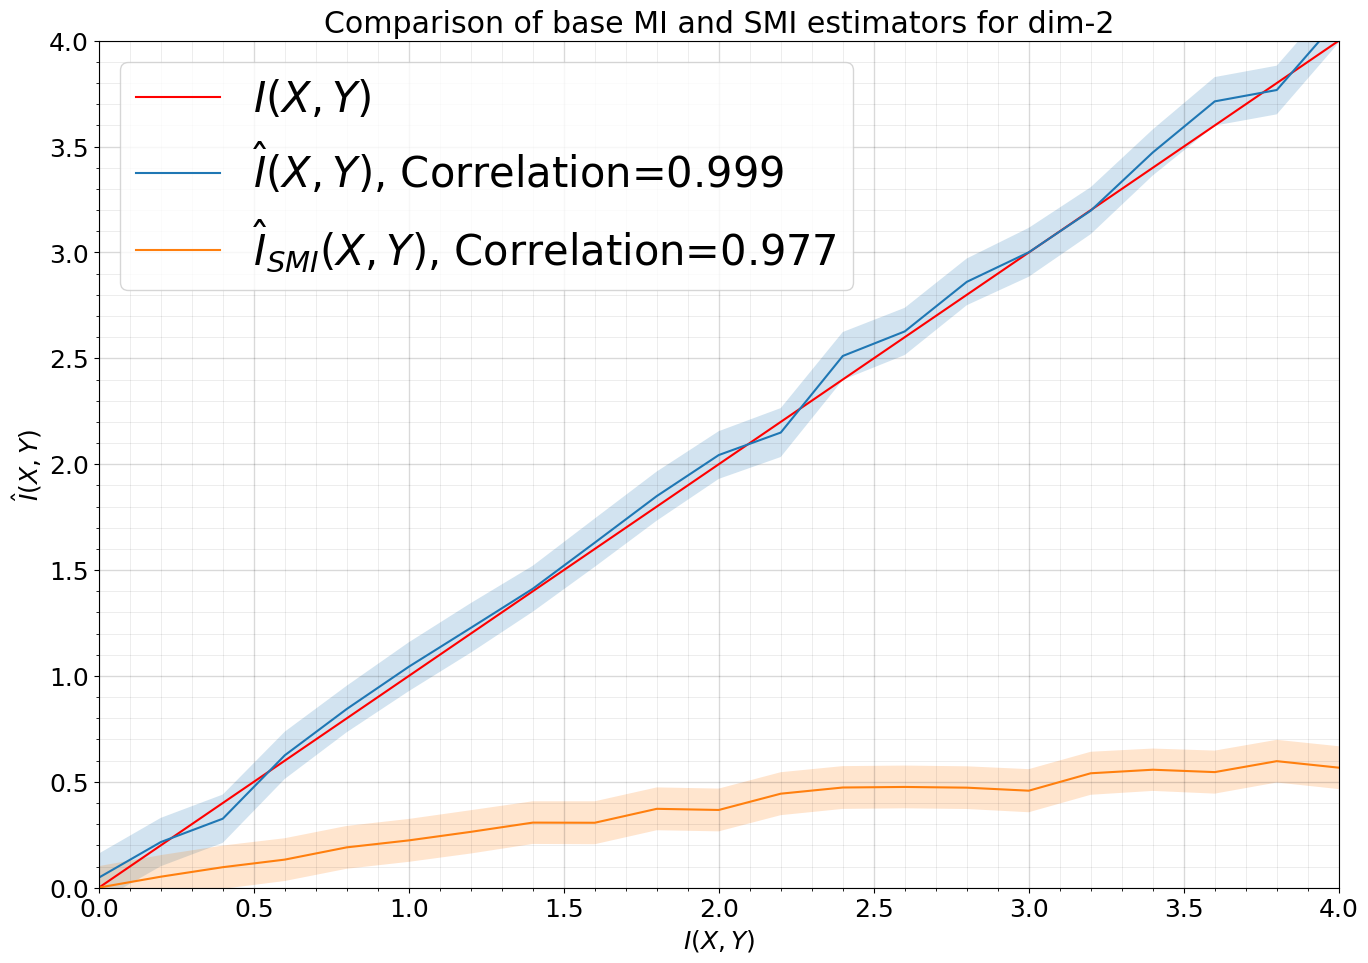

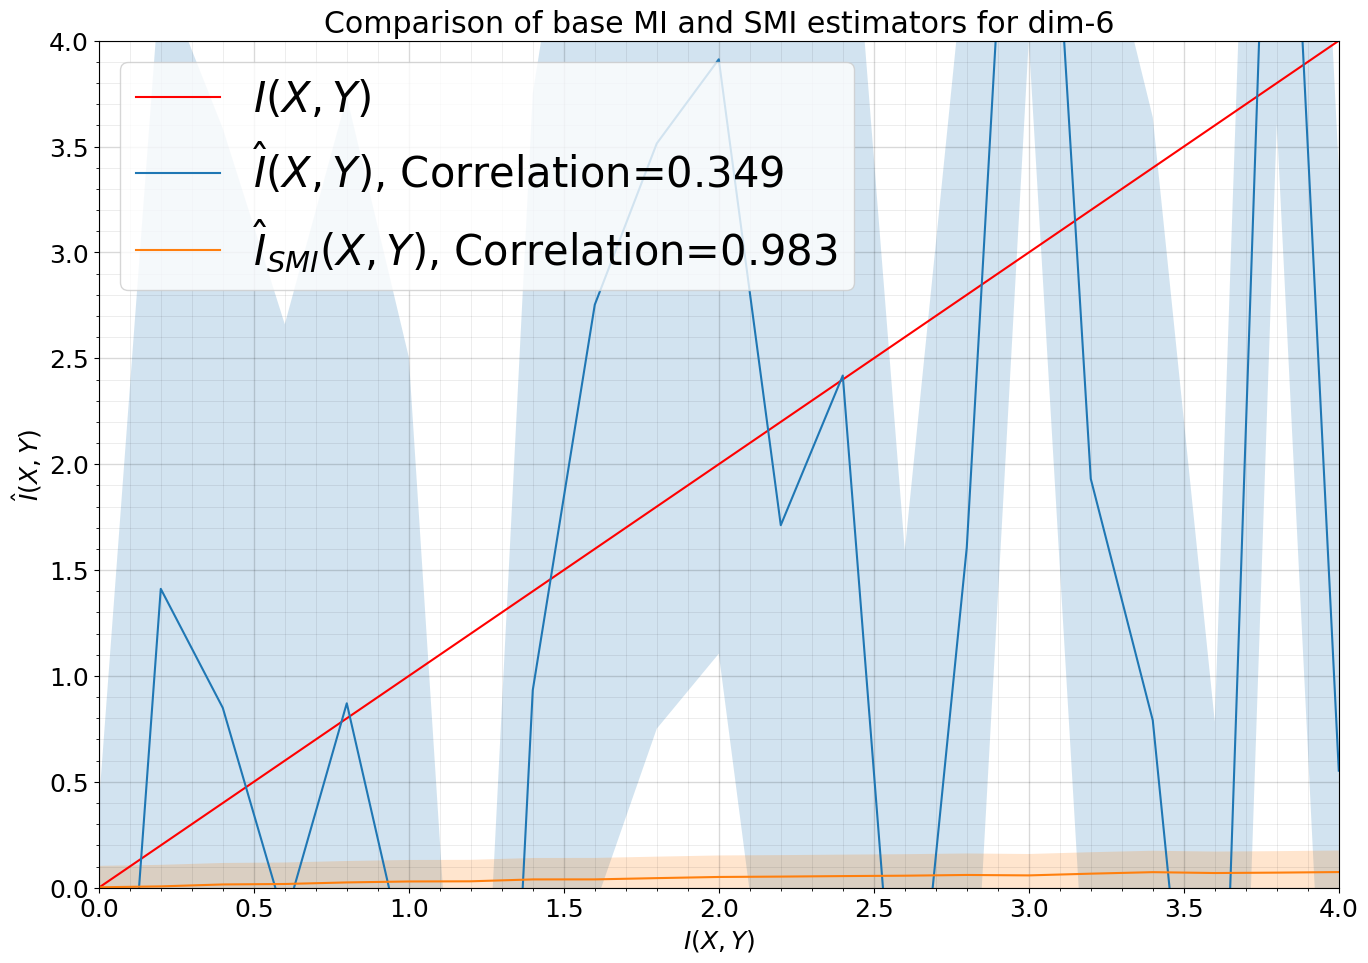

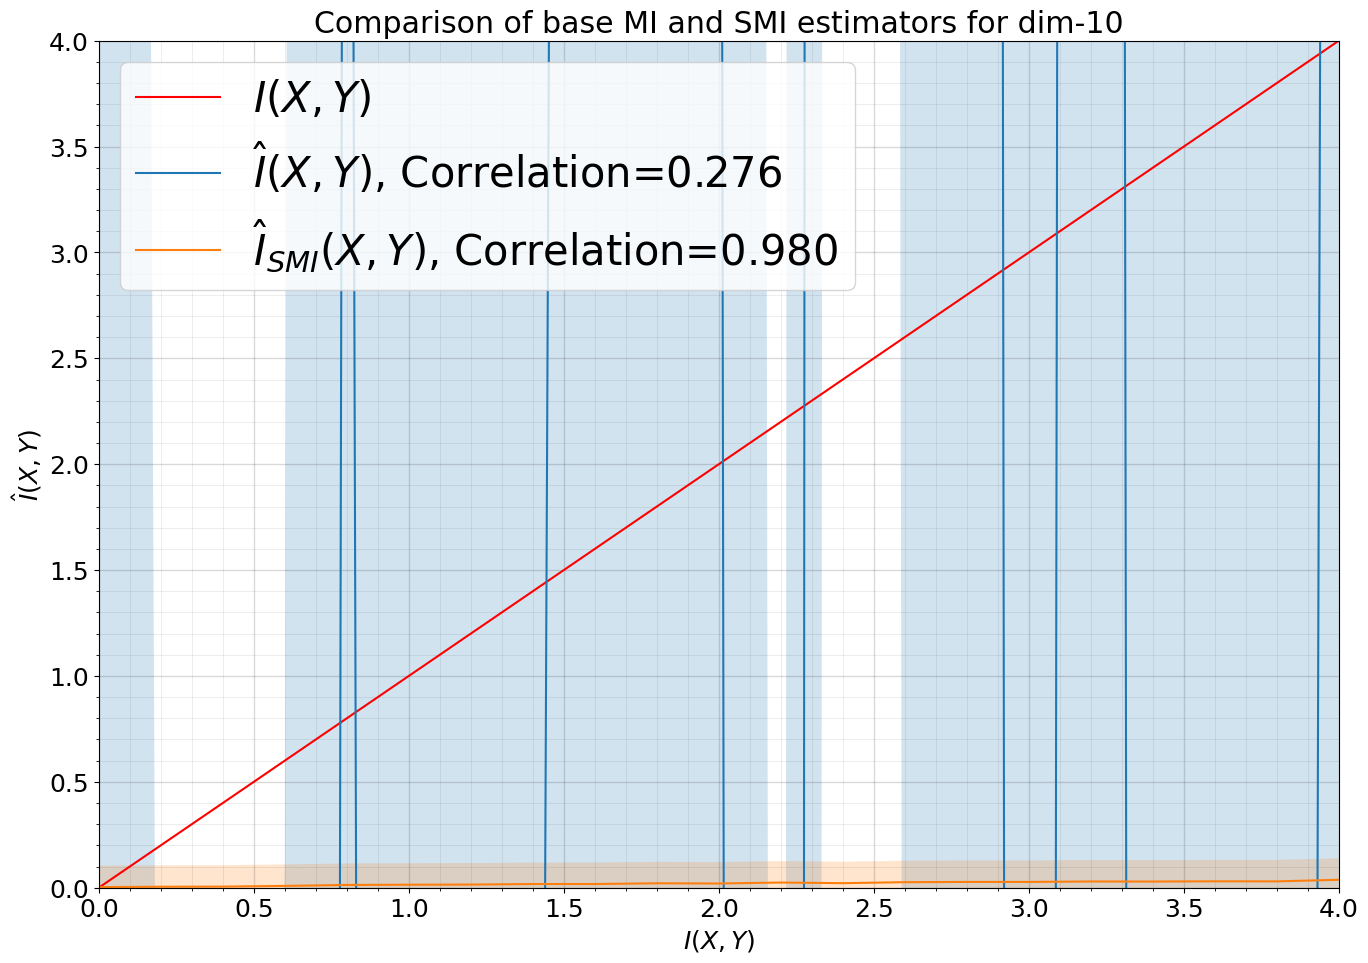

In [15]:
# The values of mutual information under study.
MI = np.linspace(0.0, 4.0, 21)
n_exps = len(MI)
# Sample size and dimensions of vectors X and Y.
n_samples = 2000 # 5000
dim_values = (1,2,6,10)

dd_results = {}
for dim_iter in tqdm(dim_values):
    dd_results[dim_iter] = {}
    
    try:
        X_dimension = dim_iter
        Y_dimension = dim_iter

        estimated_MI, estimated_MI_compressed = perform_normal_compressed_tests_MI(
            MI,
            n_samples, X_dimension, Y_dimension, _, _,
            X_compressor=None,
            Y_compressor=None,
            verbose=0,
            is_smi=True,
            n_projections=1000
        )
        
        dd_results[dim_iter]['mi'] = estimated_MI
        dd_results[dim_iter]['smi'] = estimated_MI_compressed
    
        plot_estimated_compressed_MI(
            MI, 
            estimated_MI,
            estimated_MI_compressed, 
            f"Comparison of base MI and SMI estimators for dim-{dim_iter}"
            )
    except:
        dd_results[dim_iter]['mi'] = None
        dd_results[dim_iter]['smi'] = None


#### Grid SMI correlation experiment with 10 reruns

In [16]:
import pickle 
from pathlib import Path
log_dir = Path('logs_grid_reruns10')
log_dir.mkdir(exist_ok=True)

# The values of mutual information under study.
MI = np.linspace(0.0, 4.0, 21)
n_exps = len(MI)

# Sample size and dimensions of vectors X and Y.
n_samples = 2000 # 5000

dim_values = (1,2,5,6,8,10,20,30,40,50,75,100)

list_seed_results = []

for seed_ in tqdm(range(10)):
    dd_results = {}
    for dim_iter in (dim_values):
        dd_results[dim_iter] = {}
        
        try:
            X_dimension = dim_iter
            Y_dimension = dim_iter

            estimated_MI, estimated_MI_compressed = perform_normal_compressed_tests_MI(
                MI,
                n_samples, X_dimension, Y_dimension, _, _,
                X_compressor=None,
                Y_compressor=None,
                verbose=0,
                is_smi=True,
                n_projections=1000
            )
            
            dd_results[dim_iter]['mi'] = estimated_MI
            dd_results[dim_iter]['smi'] = estimated_MI_compressed
        
            # plot_estimated_compressed_MI(
            #     MI, 
            #     estimated_MI,
            #     estimated_MI_compressed, 
            #     f"Comparison of base MI and SMI estimators for dim-{dim_iter}"
            #     )
        except:
            dd_results[dim_iter]['mi'] = None
            dd_results[dim_iter]['smi'] = None
    
    list_seed_results.append(dd_results)
    with open(log_dir/'list_mi_seed.pickle', 'wb') as handle:
                pickle.dump(list_seed_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/10 [00:00<?, ?it/s]

#### Plot correlation over dim

In [17]:
# Plotting 

len(list_seed_results)
dd_corrs = {'mi':[], 'smi':[], 'dim':[]}
for dim_ in dim_values:
    corr_mi = 0
    corr_smi = 0
    for dd_results in list_seed_results:
        dd_mi_ = dd_results[dim_]
        mi_estimate = dd_mi_['mi'][:,0]
        smi_estimate = dd_mi_['smi'][:,0]
        corr_mi += np.corrcoef(MI, mi_estimate)[0,1]
        corr_smi += np.corrcoef(MI, smi_estimate)[0,1]
        
    dd_corrs['mi'].append(corr_mi/len(list_seed_results))
    dd_corrs['smi'].append(corr_smi/len(list_seed_results))
    dd_corrs['dim'].append(dim_)

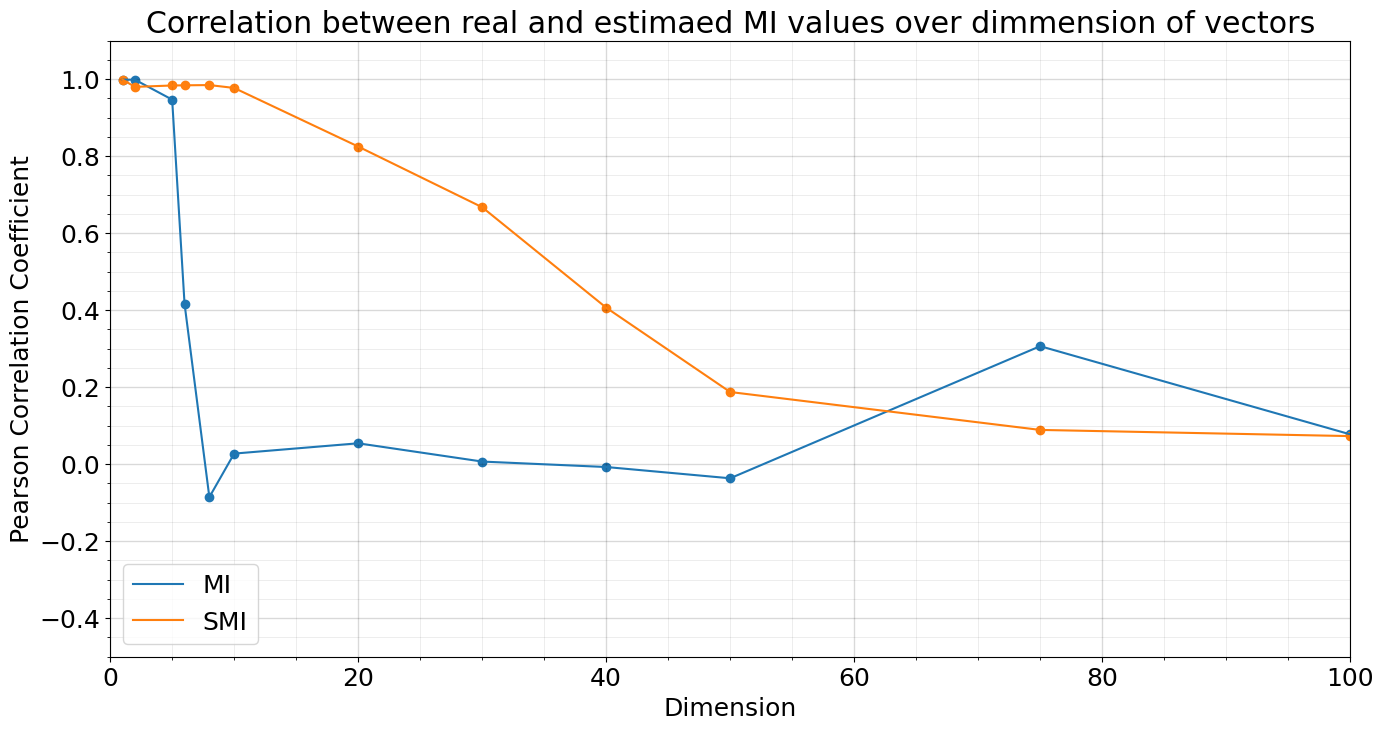

In [25]:
fig_normal, ax_normal = plt.subplots()
fig_normal.set_figheight(8)
fig_normal.set_figwidth(16)
# Grid.
ax_normal.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax_normal.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax_normal.set_title('Correlation between real and estimaed MI values over dimmension of vectors')
ax_normal.set_xlabel("Dimension")
ax_normal.set_ylabel("Pearson Correlation Coefficient")

ax_normal.minorticks_on()

ax_normal.scatter(dd_corrs['dim'], dd_corrs['mi'], )
ax_normal.plot(dd_corrs['dim'], dd_corrs['mi'], label="MI",)
ax_normal.scatter(dd_corrs['dim'], dd_corrs['smi'], )
ax_normal.plot(dd_corrs['dim'], dd_corrs['smi'], label="SMI",)

ax_normal.legend(loc='lower left')

ax_normal.set_xlim((0.0, max(dd_corrs['dim'])))
ax_normal.set_ylim((-0.5, 1.1))

plt.show();